# Advanced Lane Lines

## Camera Calibration

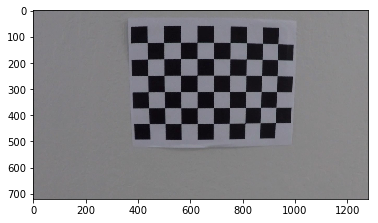

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Read in a calibration image
img = mpimg.imread('camera_cal/calibration18.jpg')
plt.imshow(img)

In [2]:
import glob

# Read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

In [3]:
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane
img_size = (0, 0)

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ...., (8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

# For every image
for filename in images:
    # Read in calibration image
    img = mpimg.imread(filename)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img_size = gray.shape[::-1]
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)

## Distortion Correction

In [7]:
"""
Camera class holding the characteristics of the camera in use.
"""
class Camera:
    def __init__(self):
        self.mtx = None
        self.dist = None
    
    """
    Function for camera calibration. Uses the cv2.calibrateCamera function
    to set the camara calibration values.
    """
    def calibrate(self, objpoints, imgpoints, imgsize):
        _, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, imgsize, None, None)
        return
    
    """
    Function for distortion correction. Uses the cv2.undistort function to
    calculate an undistorted image using the camara calibration values.
    """
    def cal_undistort(self, img):
        dst = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return dst

In [8]:
# Create camera object and calibrate the camera
camera = Camera()
camera.calibrate(objpoints, imgpoints, img_size)

In [130]:
def plot_images_side_by_side(left_img, left_title, right_img, right_title):
    """
    Display the images `leftImg` and `rightImg` side by side with image titles.
    """
    fig, axes = plt.subplots(ncols=2, figsize=(20,10))
    fig.tight_layout()
    axes[0].imshow(left_img)
    axes[0].set_title(left_title, fontsize=20)
    axes[1].imshow(right_img)
    axes[1].set_title(right_title, fontsize=20)

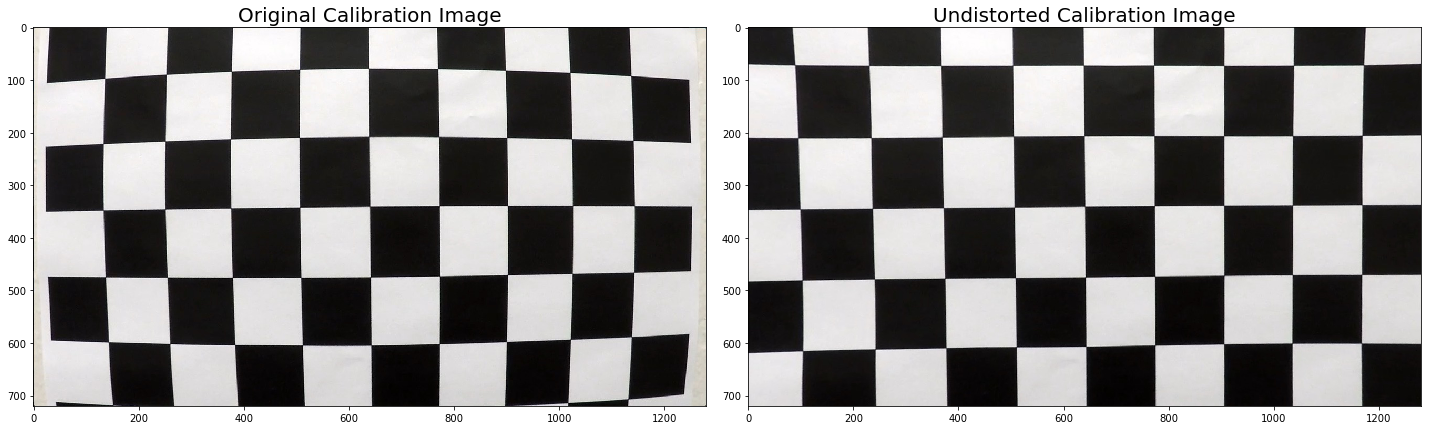

In [131]:
# Read in a test image
img = mpimg.imread('camera_cal/calibration1.jpg')
undistorted = camera.cal_undistort(img)

# Plot images (before/after)
plot_images_side_by_side(
    img, 'Original Calibration Image',
    undistorted, 'Undistorted Calibration Image'
)

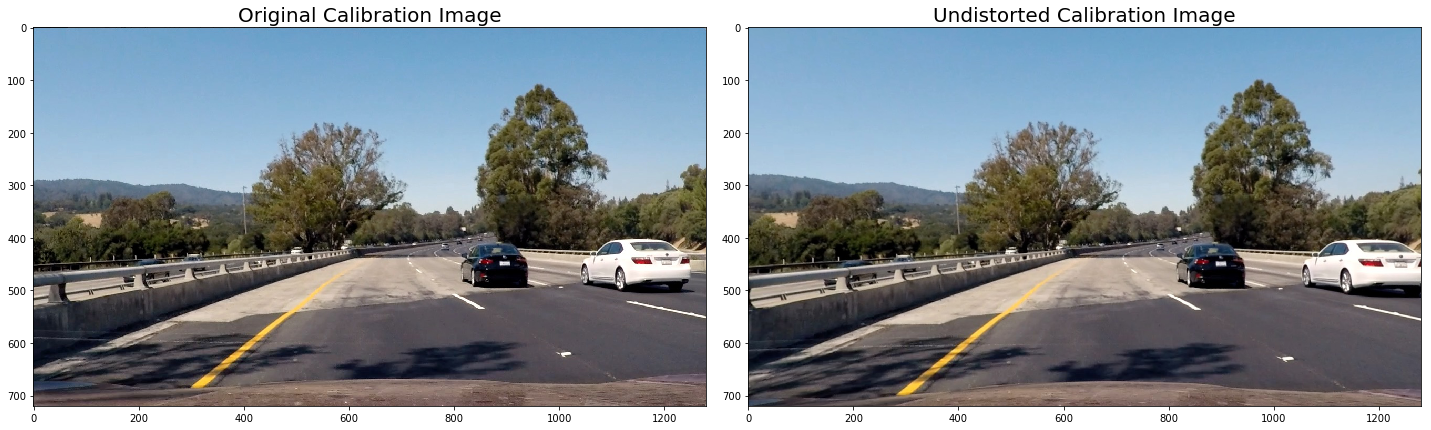

In [132]:
img = mpimg.imread('test_images/test4.jpg')
undistorted = camera.cal_undistort(img)

# Plot images (before/after)
plot_images_side_by_side(
    img, 'Original Calibration Image',
    undistorted, 'Undistorted Calibration Image'
)

## Color and Gradient Threshold

In [136]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx * sobelx + sobely * sobely)
    scaled_mag = np.uint8(255*mag/np.max(mag))
    # Apply threshold
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    # Apply threshold
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

In [137]:
def combine(img, ksize=15):
    # Choose a Sobel kernel size
    #ksize = 15 # Choose a larger odd number to smooth gradient measurements
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(10, 100))  # (10, 100)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(10, 100))   # (10, 100)
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))            # (30, 100)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))           # (0.7, 1.3)
    
    # Combine the thresholding functions
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

From Udacity Lesson #30:

In [138]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

## Perspective Transform

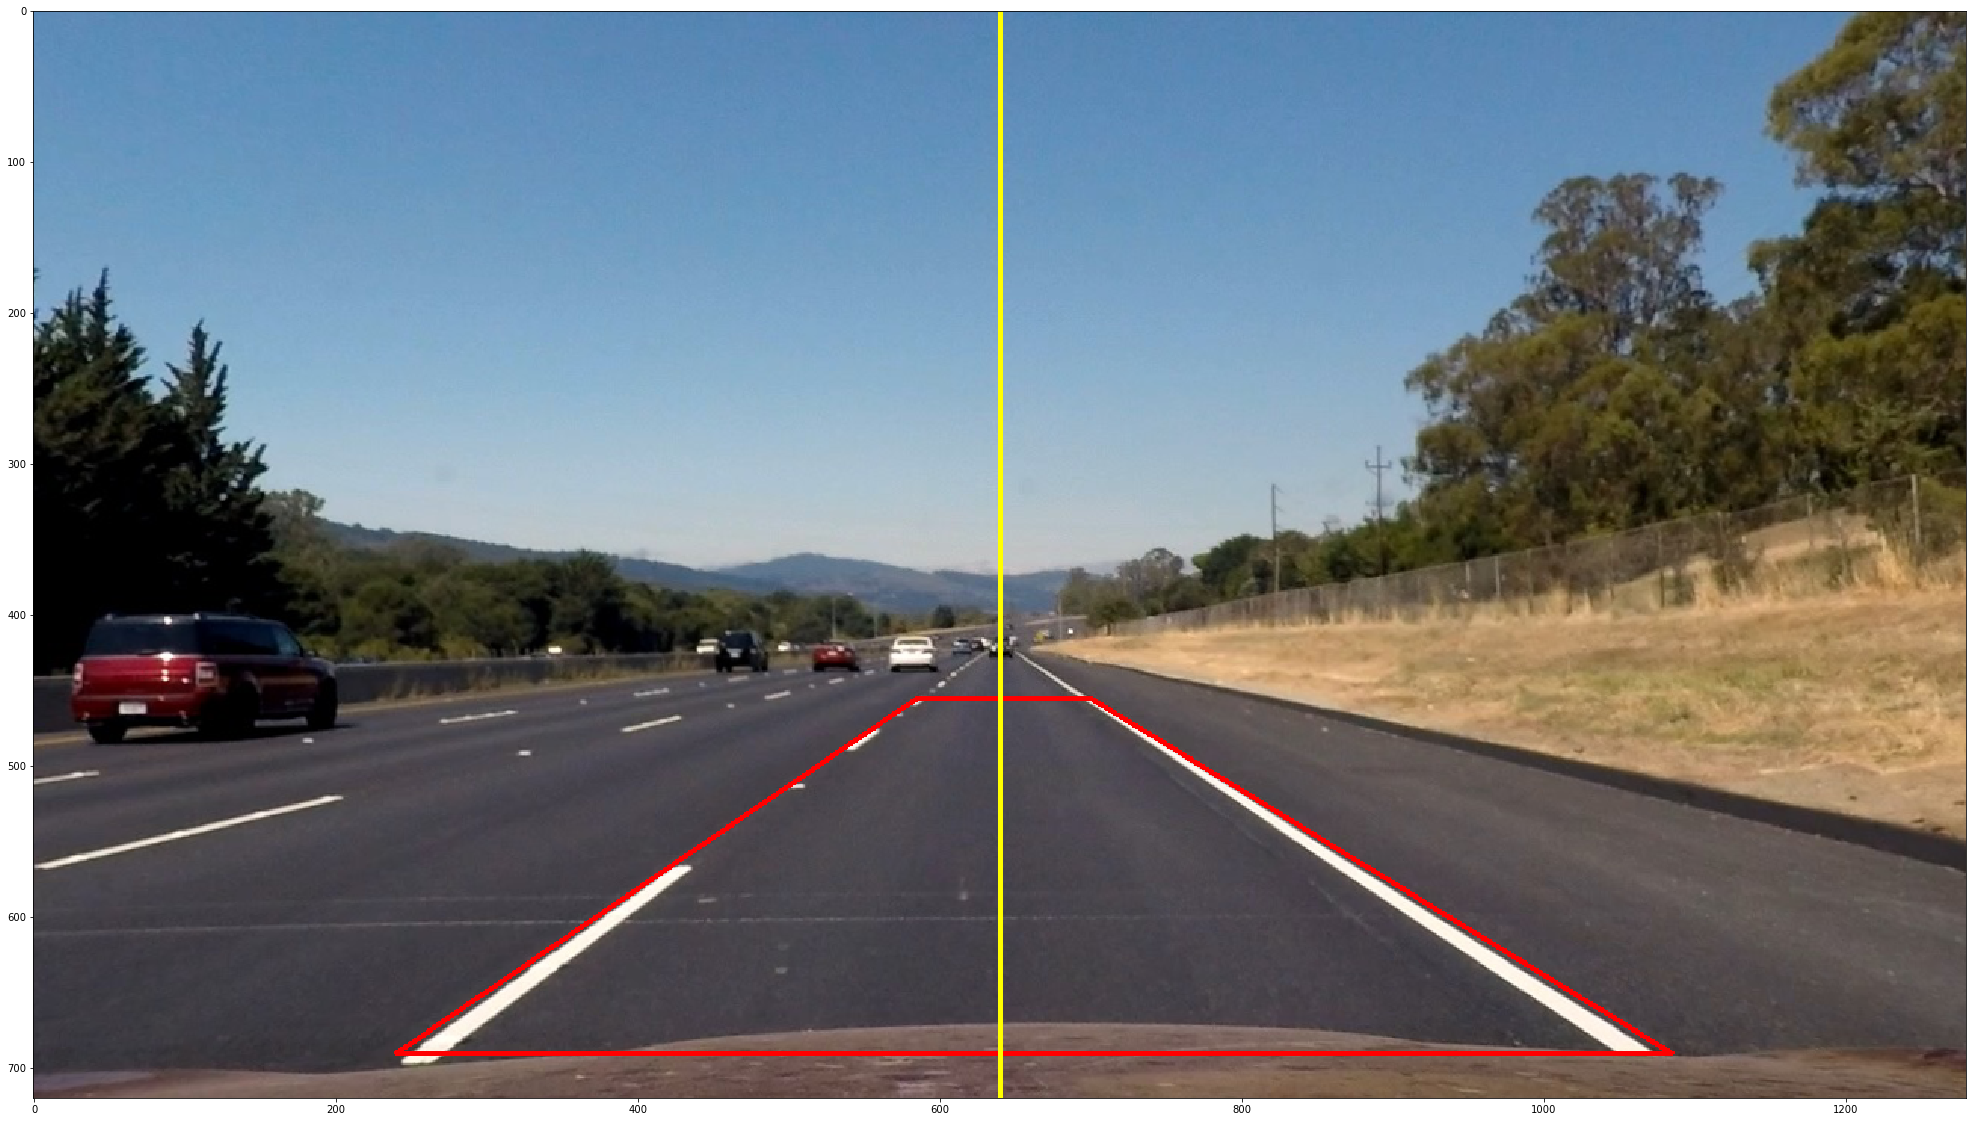

In [139]:
def perspective_transform(img):
    
    return img

# Load test images
#test_images = glob.glob('test_images/st*.jpg')

def load_images(filepath):
    images = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), glob.glob(filepath)))
    return images

test_images = load_images('./test_images/st*.jpg')

index = 0
original = cv2.cvtColor(test_images[index][1],cv2.COLOR_BGR2RGB)
undistorted = camera.cal_undistort(original)

img_size = undistorted.shape[1::-1]
copy = undistorted.copy()

bottomY = img_size[1] - 30
topY = 455

left1 = (240, bottomY)
left1_x, left1_y = left1
left2 = (585, topY)
left2_x, left2_y = left2

right1 = (700, topY)
right1_x, right1_y = right1
right2 = (1085, bottomY)
right2_x, right2_y = right2

# Plot 
color = [255, 0, 0]
w = 2
cv2.line(copy, left1, left2, color, w)
cv2.line(copy, left2, right1, color, w)
cv2.line(copy, right1, right2, color, w)
cv2.line(copy, right2, left1, color, w)
cv2.line(copy, (int(img_size[0]/2),0), (int(img_size[0]/2),img_size[1]), [255, 255, 0], w)
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(copy)

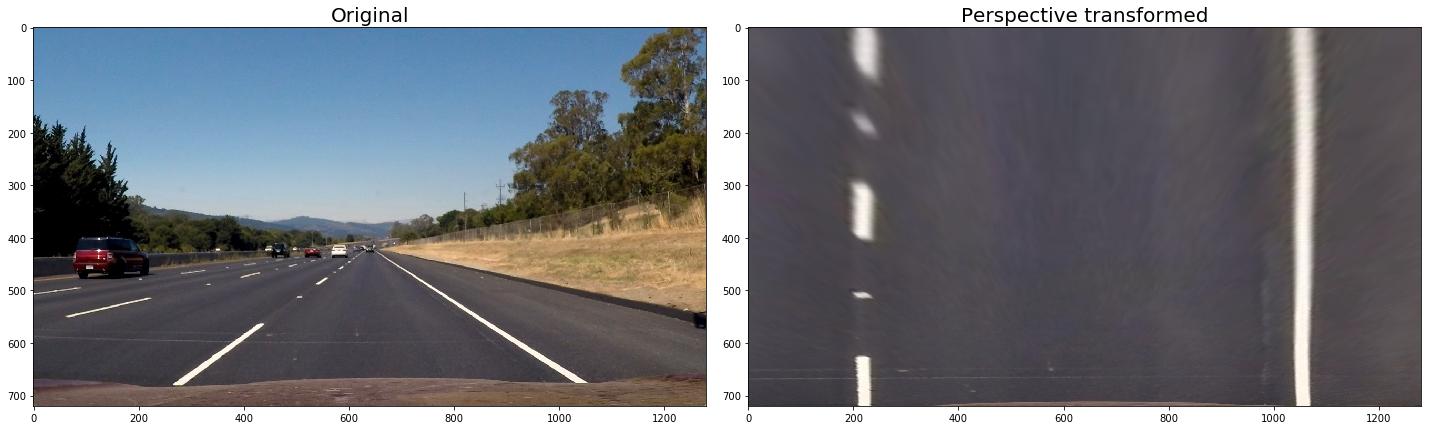

In [140]:
gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
src = np.float32([ 
    [left2_x, left2_y],
    [right1_x, right1_y],
    [right2_x, right2_y],
    [left1_x, left1_y]
])

# Using an offset on the left and right side allows the lanes to curve.
offset = 200
dst = np.float32([
    [offset, 0],
    [xSize-offset, 0],
    [xSize-offset, ySize], 
    [offset, ySize]
])

# Calculate M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the image to a top-down-view
warped = cv2.warpPerspective(undistorted, M, (xSize, ySize))

# Plot images (before/after)
plot_images_side_by_side(
    original, 'Original',
    warped, 'Perspective transformed'
)

## Detect Lane Lines

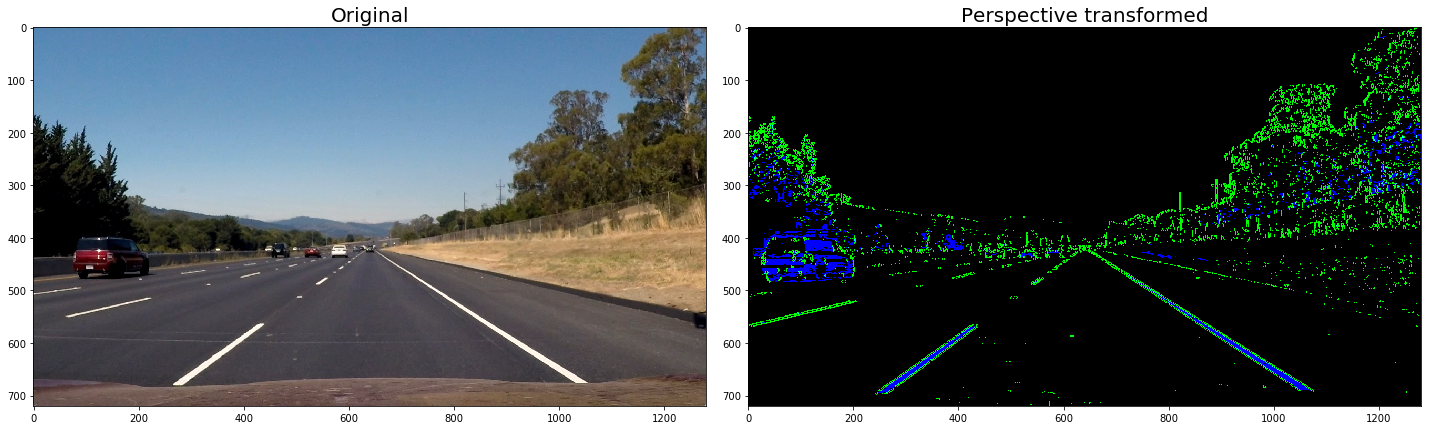

In [141]:

binary = pipeline(undistorted)

plot_images_side_by_side(
    original, 'Original',
    binary, 'Perspective transformed'
)

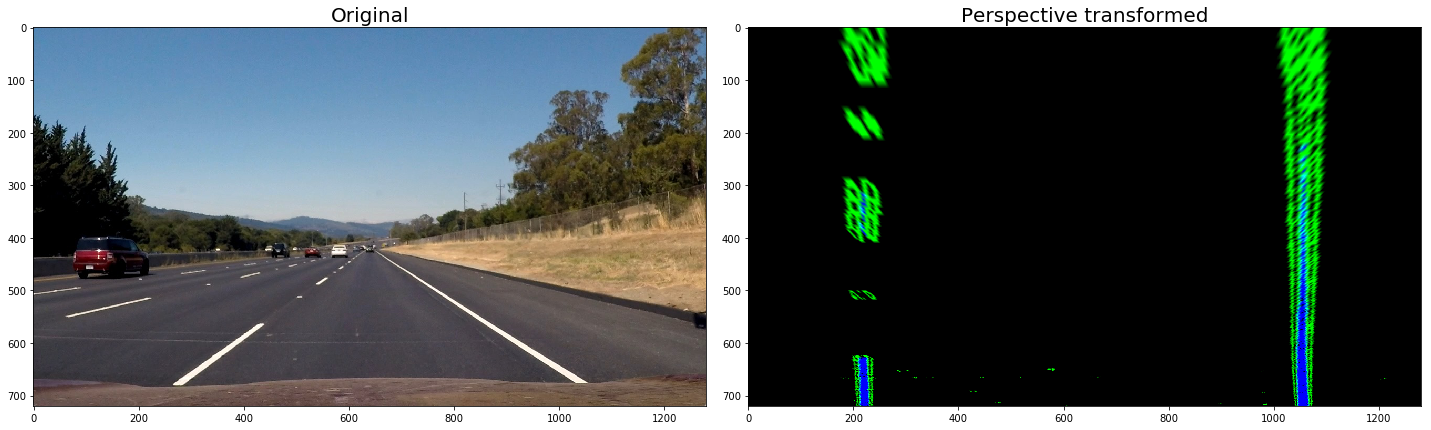

In [142]:

warped = cv2.warpPerspective(binary, M, (xSize, ySize))

plot_images_side_by_side(
    original, 'Original',
    warped, 'Perspective transformed'
)

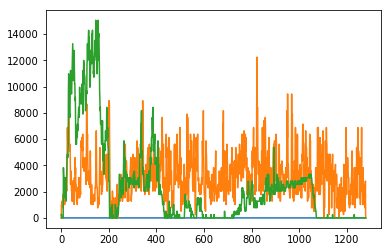

In [143]:
histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## Determine the Lane Curvature

## Now: for every image